In [4]:
import numpy as np
from scipy import fftpack
import tensorly as tl 
import time
from tensorly.decomposition import tucker
import tensorsketch
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle 
import simulation
plt.style.use('seaborn-paper')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import scipy.io
from brokenaxes import brokenaxes
from matplotlib.ticker import FormatStrFormatter
from plot_util import *

In [7]:
def sim_name(gen_type,r,noise_level,dim, rm_typ): 
    """
    Obtain the file name to use for a given simulation setting
    """
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)+ "_" + rm_typ
def gen_sparse_ten(n,nnz,r, dim = 3,noise_level = 1e-3):
    """ 
    Generate sparse tensor based on TensorSketch (https://papers.nips.cc/paper/8213-low-rank-tucker-decomposition-of-large-tensors-using-tensorsketch)
    The number of non-zero entry of the obtain tensor is approximately nnz. 
    """
    density = (1 - (1 - nnz**(1/dim)/n)**(1/r))*r
    core_tensor = np.random.normal(0,1,[r for _ in range(dim)])
    arms = []
    tensor = core_tensor
    for i in np.arange(dim): 
        arm =  np.random.normal(0,1,size = (n,r))
        arm = arm*np.random.binomial(1,density,size=(n,r))
        arms.append(arm)
        tensor = tl.tenalg.mode_dot(tensor, arm, mode=i) 
    tensor0 = tensor
    tensor = tensor + np.random.normal(0,1,size = [n for _ in range(dim)])*noise_level
    return tensor, tensor0 

def avg_sim_list(sim_list): 
    sim_list_new = []
    for sims in sim_list: 
        sim_list_new.append(np.mean(sims, axis = 0)) 
    return sim_list_new

def TS_mem_cost(K,r = 10,dim = 3): 
    """
    Total memory cost for using TensorSketch 
    """
    return K*r**(2*dim-2) + K*r**(2*dim)
def one_pass_mem_cost(k,dim = 3,n = 300):
    """
    Total memory cost for using one-pass sketching 
    """
    return k*dim*n + (2*k+1)**dim

def mem_to_K(mem, r = 10, dim = 3):  
    
    # Here, we do not set K to be integer, since K is just a constant, and we only need J1,J2 to be integer
    return (mem/r**(2*dim -2)/(r**2+1))

In [8]:
def journal_nssim(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 28, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    sim_list = []
    if outside: 
        plt.figure(figsize = (6,5))
    else: 
        plt.figure(figsize = (6,5))
    set_plot(fontsize)
    alldata = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))        
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, n//2, n//20) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r, n//5, n//50)
        else: 
            ks = np.arange(r, n//10, n//100)
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        one_pass_result_diff = np.mean(sim_list[i][plot_id][1],0) - hosvd_result
        alldata.append(one_pass_result_diff)
        plt.plot(ks/n, one_pass_result_diff, label = find_rm_label(rm_typ), markersize = 10, marker = marker('1pass', rm_typ), color = marker_color('1pass',rm_typ), markeredgewidth=1, markerfacecolor='None') 
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title(find_gen_label(gen_type), fontsize = fontsize)
    # plt.legend(loc = 'best', fontsize = fontsize)
    # plt.yscale('log')
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)
    ymin = np.min(alldata)
    plt.ylim(ymin, ymax)
    if outside: 
        leg = plt.legend(fontsize = fontsize, bbox_to_anchor=(2, 0.85))
    plt.xlabel('k/I')
    plt.ylabel('Regret')  
    plt.savefig('plots/journal/'+name,bbox_inches = "tight",pad_inches=0)
    plt.show()

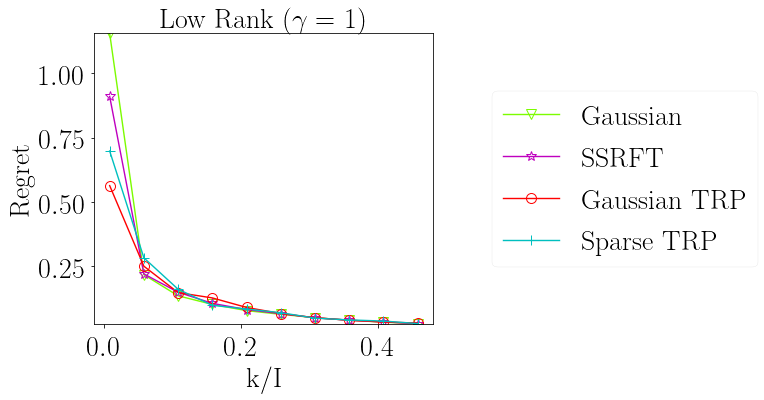

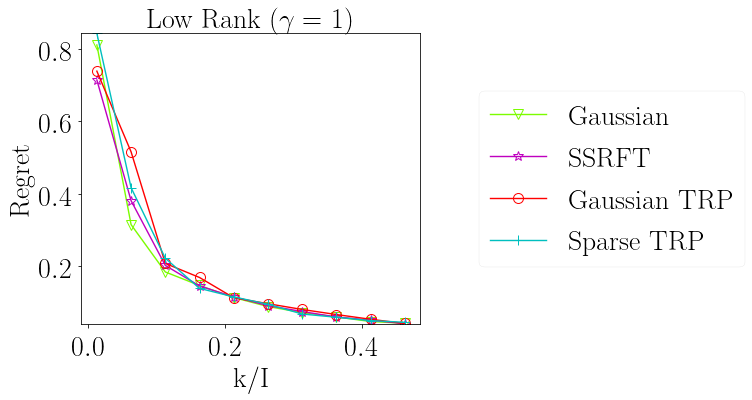

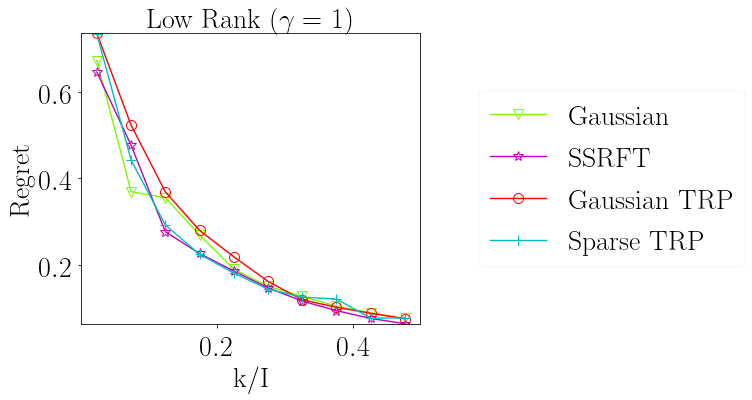

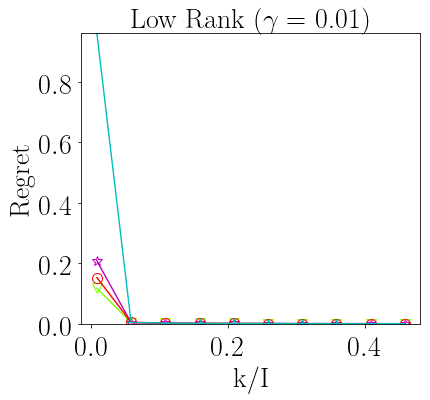

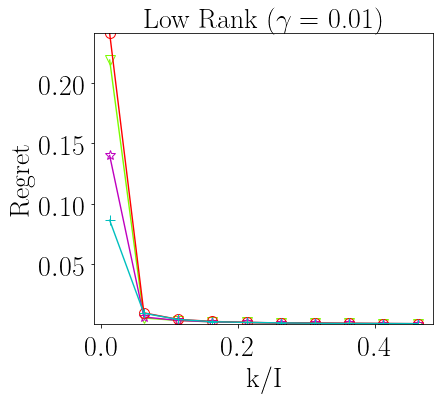

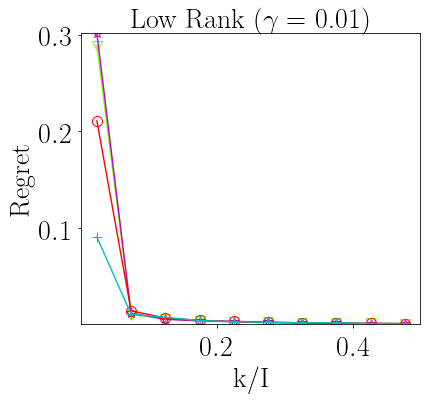

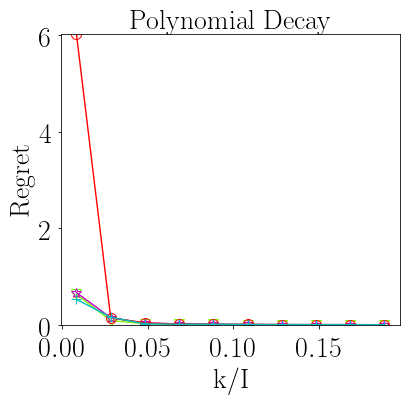

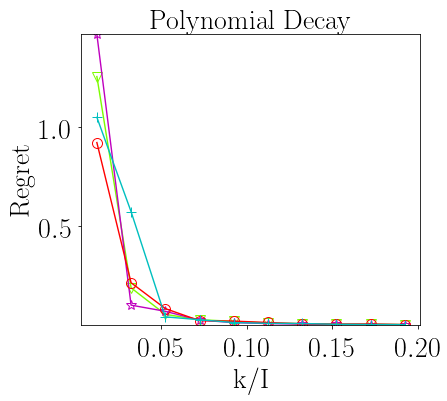

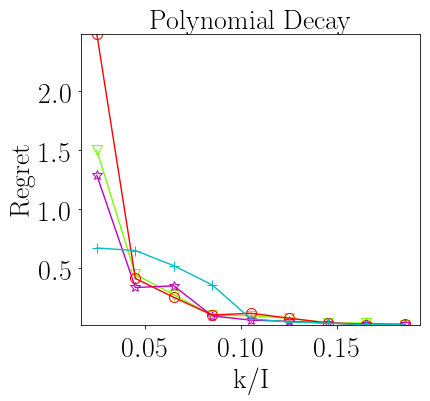

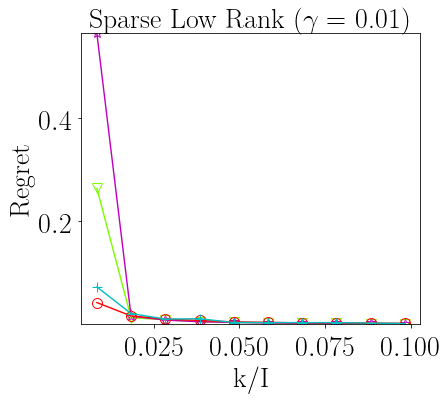

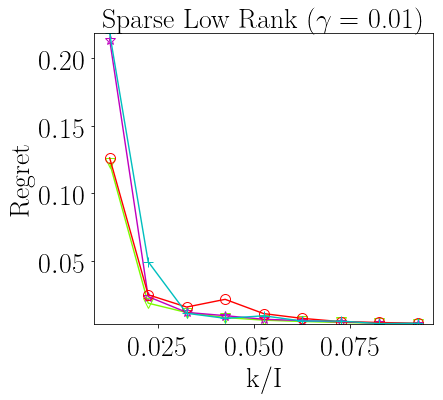

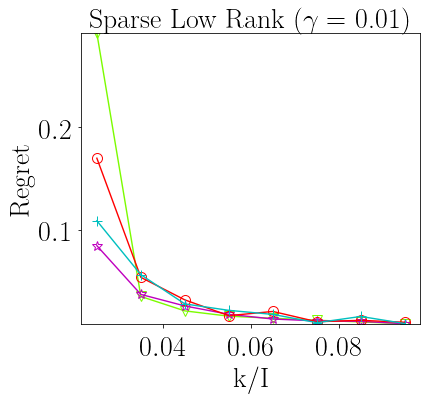

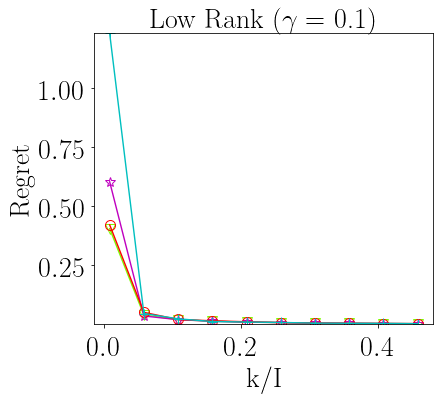

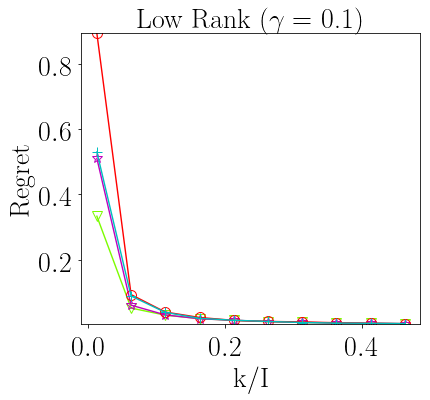

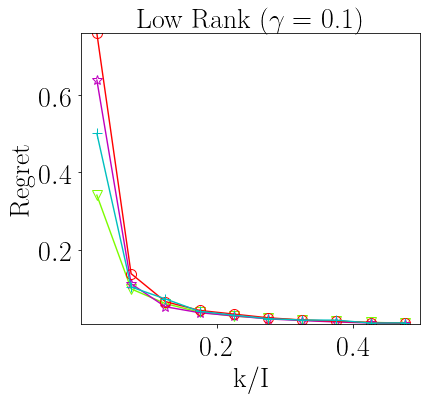

In [9]:
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_600.pdf",600, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_400.pdf",400, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_200.pdf",200, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_200.pdf",200)

In [ ]:
def journal_nssim2(rm_typs,gen_type,r,noise_level,name,n, ns = [200, 400, 600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 28, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    sim_list = []
    if outside: 
        plt.figure(figsize = (6,5))
    else: 
        plt.figure(figsize=(6,5))
    set_plot(fontsize)
    set_plot(fontsize)
    ymaxs = []
    ymins = []
    alldata = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hosvd_result = np.mean(sim_list[i][plot_id][2][:]) 
        print(hosvd_result)
        two_pass_result = np.mean(sim_list[i][plot_id][0],0) 
        one_pass_result = np.mean(sim_list[i][plot_id][1],0) 
        plt.plot(ks/n, one_pass_result, label = find_rm_label(rm_typ)+" 1-Pass", markersize = 10, marker = marker('1pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
        plt.plot(ks/n, two_pass_result, label = find_rm_label(rm_typ)+" 2-Pass", markersize = 10, marker = marker('2pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
        plt.axhline(y=hosvd_result, color='r', linestyle='-')
        alldata.append(one_pass_result)
        alldata.append(two_pass_result)
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title(find_gen_label(gen_type), fontsize = fontsize)

    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(2.1, 0.85))
    # plt.yscale('log')
    plt.xlabel('k/I')
    plt.ylabel('Relative Error')
    
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)
    ymin = np.min(alldata)
    ymin = np.min((hosvd_result, ymin))
    # ymax = 10**np.ceil(np.log10(ymax))
    # ymin = 10**np.floor(np.log10(ymin))
    plt.ylim(ymin-0.01, ymax)
    plt.savefig('plots/journal/'+name,bbox_inches = "tight",pad_inches=0)
    plt.show()